In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from init_objects import *
from functions.stylizedfacts import *
from functions.helpers import organise_data
from functions.inequality import gini, lorenz_curve
from qe_inequality_model import *
import statsmodels.api as sm
from matplotlib import style
import scipy.stats as stats
from statsmodels.iolib.summary2 import summary_col
from functions.find_bubbles import *

In [2]:
style.use('ggplot')

In [3]:
def confidence_interval(data, av):
    sample_stdev = np.std(data)
    sigma = sample_stdev/math.sqrt(len(data))
    return stats.t.interval(alpha = 0.95, df= 24, loc=av, scale=sigma) 

# QE experiment

In [20]:
NRUNS = 2
burn_in_period = 0

In [21]:
params = {"fundamental_values": [105, 166], "asset_types": ['stock', 'stock'],
              "trader_sample_size": 22, "n_traders": 500,
              "ticks": 500, "std_fundamentals": [0.1, 0.1],
              "std_noise": 0.00107, "w_random": 0.1,
              "strat_share_chartists": 0.8,
              "init_assets": [100, 100], "base_risk_aversion": 1.0,
              'spread_max': 0.004087, "horizon": 200,
              "fundamentalist_horizon_multiplier": 0.2,
              "trades_per_tick": 3, "mutation_intensity": 0.0,
              "average_learning_ability": 0.0,
              "bond_mean_reversion": 0.8,
              "qe_perc_size": 0.0, "qe_start": 10, "qe_end": 16, "qe_asset_index": 0}

In [22]:
qe_size = [x / 100.0 for x in range(0, 100, 50)]
qe_size

[0.0, 0.5]

In [23]:
experiments = len(qe_size)

In [24]:
full_qe_size = []
for exp in range(experiments):
    for seed in range(NRUNS):
        full_qe_size.append(qe_size[exp])

In [25]:
trdrs = []
orbs = []
central_banks = []

for exp in range(experiments):
    params['qe_perc_size'] = qe_size[exp]
    for seed in range(NRUNS): 
        traders, central_bank, orderbook = init_objects_qe_ineq(params, seed)
        traders, central_bank, orderbook = qe_ineq_model(traders, central_bank, orderbook, params, seed)
        central_banks.append(central_bank)
        trdrs.append(traders)
        orbs.append(orderbook)

Start of simulation  0
Start of simulation  1
Start of simulation  0
Start of simulation  1


# QE effects 

## 1 On prices

In [32]:
asset_prices = []
asset_fundamentals = []
asset_volumes = []

for idx, a in enumerate(params['asset_types']):
    ap = pd.DataFrame([orbs[run][idx].tick_close_price for run in range(NRUNS * experiments)]).transpose()
    asset_prices.append(ap)
    
    fn = pd.DataFrame([orbs[run][idx].fundamental for run in range(NRUNS * experiments)]).transpose()
    asset_fundamentals.append(fn)
    
    av = pd.DataFrame([[sum(v) for v in orbs[run][0].transaction_volumes_history] for run in range(NRUNS * experiments)]).transpose()
    asset_volumes.append(av)

In [76]:
av_p0_experiments = []
av_p1_experiments = []

av_fn0_experiments = []
av_fn1_experiments = []

av_vol0_experiments = []
av_vol1_experiments = []

for x in range(experiments):
    y = x*NRUNS
    
    #prices
    p0 = asset_prices[0][range(y,y+NRUNS)]
    av_p0_experiments.append(p0.mean(axis=1))
    
    p1 = asset_prices[1][range(y,y+NRUNS)]
    av_p1_experiments.append(p1.mean(axis=1))
    
    # fundamentals
    f0 = asset_fundamentals[0][range(y,y+NRUNS)]
    av_fn0_experiments.append(f0.mean(axis=1))
    
    f1 = asset_fundamentals[1][range(y,y+NRUNS)]
    av_fn1_experiments.append(f1.mean(axis=1))
    
    # volumes
    v0 = asset_volumes[0][range(y,y+NRUNS)]
    av_vol0_experiments.append(v0.mean(axis=1))
    
    v1 = asset_volumes[0][range(y,y+NRUNS)]
    av_vol1_experiments.append(v1.mean(axis=1))

Text(0, 0.5, 'Volume')

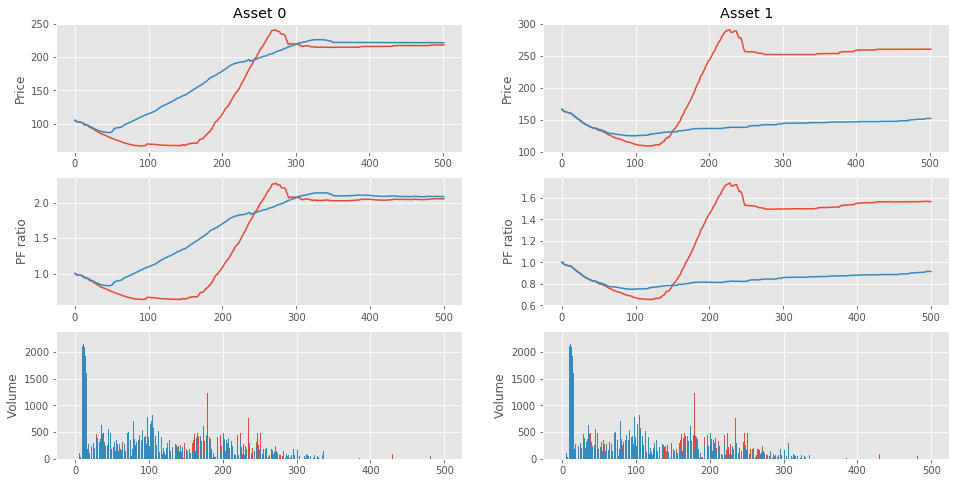

In [79]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(16,8))

# prices
ax1.set_title('Asset 0')
ax1.plot(av_p0_experiments[0].index, av_p0_experiments[0], label='no-qe')
ax1.plot(av_p0_experiments[1].index, av_p0_experiments[1], label='qe')
ax1.set_ylabel('Price')

ax2.set_title('Asset 1')
ax2.plot(av_p1_experiments[0].index, av_p1_experiments[0], label='no-qe')
ax2.plot(av_p1_experiments[1].index, av_p1_experiments[1], label='qe')
ax2.set_ylabel('Price')

# pf ratio's 
ax3.plot(av_p0_experiments[0].index, av_p0_experiments[0] / av_fn0_experiments[0])
ax3.plot(av_p0_experiments[1].index, av_p0_experiments[1] / av_fn0_experiments[1])
ax3.set_ylabel('PF ratio')

ax4.plot(av_p1_experiments[0].index, av_p1_experiments[0] / av_fn1_experiments[0])
ax4.plot(av_p1_experiments[1].index, av_p1_experiments[1] / av_fn1_experiments[1])
ax4.set_ylabel('PF ratio')

# volumes
ax5.bar(av_vol0_experiments[0].index, av_vol0_experiments[0])
ax5.bar(av_vol0_experiments[1].index, av_vol0_experiments[1])
ax5.set_ylabel('Volume')

ax6.bar(av_vol1_experiments[0].index, av_vol1_experiments[0])
ax6.bar(av_vol1_experiments[1].index, av_vol1_experiments[1])
ax6.set_ylabel('Volume')


## 2 On inequality